# ENG4200 Coursework 1 
**Student Name：** Wang Jinghao  

**ID：** 3173768W

**Dataset：** Abalone Dataset

**Introduction:** This experiment used the linear regression method to analyze and model the abalone age dataset provided on Kaggle, aiming to predict the age of abalones (since the age of abalones is determined by the number of rings, the dataset and the subsequent experimental content use 'Rings' to represent abalone age). In the experiment, I mainly used the ridge regression model and combined it with 5-fold cross-validation and GridSearchCV for hyperparameter tuning.

**The objectives of the experiment include:**
- Exploring the relationships between data features.
- Building a complete machine learning pipeline.
- Evaluating model performance.
- Reducing overfitting through cross-validation and regularization.

## Step 1. Data Loading

###  Data Description
The Abalone dataset contains the physical characteristics of abalones and the corresponding number of rings. The goal is to predict `Rings` (an indicator of age), with input variables including:
- Length
- Diameter
- Height
- Weight characteristics(Whole, Shucked, Viscera, Shell weight)
- Gender: M, F, I


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import sys
import sklearn
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Read and view the first few rows of data
df = pd.read_csv("abalone.data.csv")
df.head()
print(df.shape)
df.info()
df.describe()


(4177, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


###  Data Exploration
To understand which features are highly correlated with the age of abalones, a correlation analysis was conducted on the numerical features in the experiment, and a heatmap was drawn.

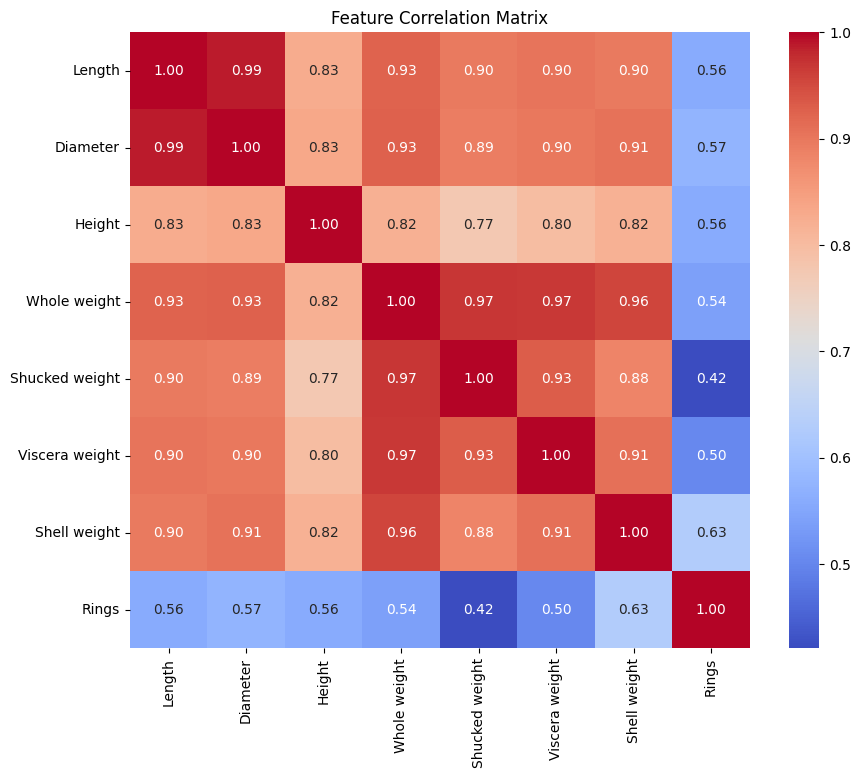

In [3]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation of numerical features and plot a heatmap
corr = numeric_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


## Step 2. Data Check

In [4]:
# Check for missing values
print("Missing Value Statistics：")
print(df.isnull().sum())


Missing Value Statistics：
gender            0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64


## Step 3. Data Cleaning and Preprocessing

This step is attempting to：
- Remove numerical outliers (Z-Score > 3).
- Print the number of samples before and after processing to check the effect.
- Perform One-Hot encoding on the categorical feature 'gender'
- Split features X and target y.
- Standardize features uniformly using a Pipeline to avoid redundancy.

In [5]:
# 1.Outlier Handling
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
clean = df[(np.abs(stats.zscore(df[numeric_features])) < 3).all(axis=1)]
print("Number of rows before processing:", df.shape[0])
print("Number of processed rows:", clean.shape[0])

# 2. Apply One-Hot encoding to gender
if 'gender' not in clean.columns:
    raise ValueError("The 'gender' column is missing from the data")
print(clean.columns)
clean = pd.get_dummies(clean, columns=['gender'], drop_first=True)
print(clean.columns)

# 3. Split features and target
x = clean.drop("Rings", axis=1)
y = clean["Rings"]


Number of rows before processing: 4177
Number of processed rows: 4027
Index(['gender', 'Length', 'Diameter', 'Height', 'Whole weight',
       'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings'],
      dtype='object')
Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Rings', 'gender_I', 'gender_M'],
      dtype='object')


It can be seen that after removing outliers using the Z-Score method, a total of 150 abnormal samples were eliminated. And the `gender` column is split into numerical indicator columns `gender_I` and `gender_M`.This allows categorical variables to be encoded into numerical values to avoid multicollinearity.

## Step 4. Dividing the training set and test set
Divide the dataset into 80% training set and 20% test set.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

print("Number of training set samples:", x_train.shape[0])
print("Number of testing set samples:", x_test.shape[0])


Number of training set samples: 3221
Number of testing set samples: 806


## Step 5. Model training, tuning, and prediction
This step uses Ridge regression to build a predictive model and adjusts the regularization parameters through GridSearchCV to prevent overfitting.

Training time: 0.2364s
Best alpha: {'ridge__alpha': 1}
Best Average Training Set R²: 0.5216154765132678
Predicted time: 0.0020s
TEST R²: 0.5170
TEST RMSE: 1.9788
TEST MAE: 1.4561


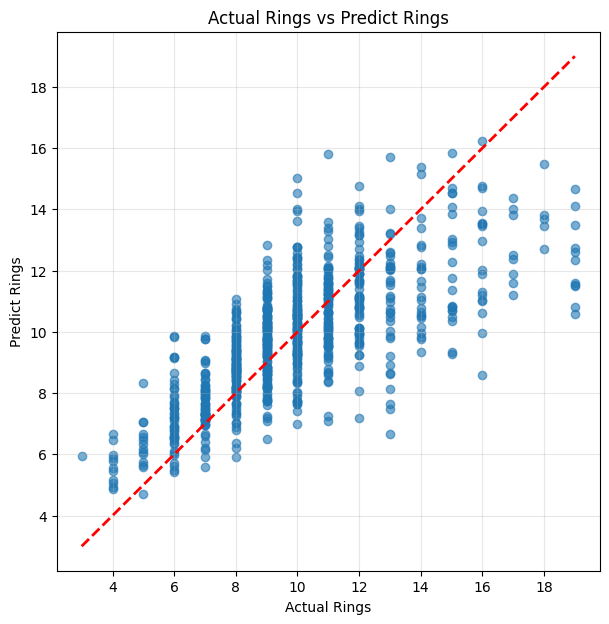

In [ ]:
# 1. Define
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# 2. Tune Parameters and Perform Cross-validation
param = {
    'ridge__alpha': [0.1, 1, 10, 100]
}

grid = GridSearchCV(pipeline, param, cv=5, scoring='r2')
start_train = time.time()
grid.fit(x_train, y_train)
end_train = time.time()
training_time = end_train - start_train
print(f"Training time: {training_time:.4f}s")

print("Best alpha:", grid.best_params_)
print("Best Average Training Set R²:", grid.best_score_)

# 3. Predict Test Set 
best_model = grid.best_estimator_
start_pred = time.time()
y_pred = best_model.predict(x_test)
end_pred = time.time()
prediction_time = end_pred - start_pred
print(f"Predicted time: {prediction_time:.4f}s")


print("\nRidge Coefficient Interpretation:")
feature_names = x_train.columns
coef_values = best_model.named_steps['ridge'].coef_

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef_values
}).sort_values(by="Coefficient", ascending=False)

print(coef_df)


# 4. Test set metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"TEST R²: {r2:.4f}")
print(f"TEST RMSE: {rmse:.4f}")
print(f"TEST MAE: {mae:.4f}")

# 5. Visualization
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual Rings")
plt.ylabel("Predict Rings")
plt.title("Actual Rings vs Predict Rings")
plt.grid(alpha=0.3)
plt.show()


In [8]:
cv_scores = cross_val_score(best_model, x_train, y_train, cv=5, scoring='r2')
print("5-fold cross-validation R²:", np.round(cv_scores, 4))
print("average R²:", np.round(np.mean(cv_scores), 4))


5-fold cross-validation R²: [0.5234 0.5153 0.5236 0.5564 0.4894]
average R²: 0.5216


To evaluate the model's generalization ability, we performed 5-fold cross-validation on the training set. The R² values for each fold were 0.5234, 0.5153, 0.5236, 0.5564, and 0.4894, with an average R² of 0.5216. The results indicate that the performance fluctuation among the folds is small, suggesting that the model performs stably across different subsets without severe overfitting or underfitting. Combined with the test set metrics, it can be seen that the Ridge regression model demonstrates good generalization ability on this dataset.

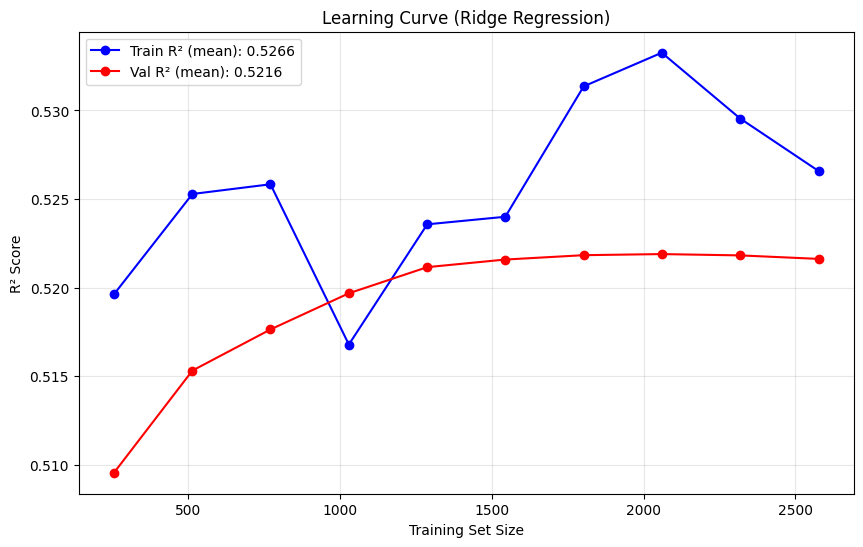

In [9]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model, x_train, y_train, cv=5, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10,6)) 
plt.plot(train_sizes, train_mean, 'o-', color='blue', label=f"Train R² (mean): {train_mean[-1]:.4f}")
plt.plot(train_sizes, val_mean, 'o-', color='red', label=f"Val R² (mean): {val_mean[-1]:.4f}")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve (Ridge Regression)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


The R² of the training set is slightly higher than that of the validation set, but the gap is not large, indicating that the model has some variance but not high bias. Overall, the trend suggests that as the number of training samples increases, the model's generalization ability gradually improves. The performance on the validation set can be further enhanced by increasing the training data or appropriately adjusting the regularization parameter α.

### Step 6. Summary
It can be observed from the prediction results that   
- Ridge regression achieves relatively stable performance on the Abalone dataset.
- The average R² is approximately 0.52, indicating that the model has moderate predictive ability；The R² of the training set is slightly higher than that of the validation set, but the gap is not large, indicating that the model has some variance but the degree of bias is not high.
- Hyperparameter tuning through grid search can significantly improve the model's generalization ability.
- Regularization terms can effectively control the risk of overfitting.

### Direction for Improvement
The results of this experiment are good, but there is still room for some improvements and attempts in certain areas.
- Try different regression methods, such as polynomial regression or Lasso regression.
- Explore feature interaction terms.
- Use nonlinear models (such as Random Forest or SVR) to further improve prediction accuracy.
- The performance on the validation set can be further improved by increasing the training data or appropriately adjusting the regularization parameter α.


In [10]:
print("Python:", sys.version)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)

print("\nPipelines used:")
print("Regression (Ridge Regression Pipeline):", pipeline)



Python: 3.9.10 (tags/v3.9.10:f2f3f53, Jan 17 2022, 15:14:21) [MSC v.1929 64 bit (AMD64)]
NumPy: 1.26.4
Pandas: 2.2.2
scikit-learn: 1.5.1

Pipelines used:
Regression (Ridge Regression Pipeline): Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge())])
